# Analyze Metal uptake

In [1]:
from IPython.display import display, HTML, Math, Markdown
display(HTML("<style>.container { width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2

In [2]:
from coralme.builder.main import MEBuilder, MEReconstruction, METroubleshooter
from coralme.builder.curation import MECurator, MEManualCuration
from coralme.builder.helper_functions import flux_based_reactions,exchange_single_model
import coralme
import pickle
import pandas
import os
import tqdm
import numpy
import json
pandas.set_option('display.max_colwidth', None)
from coralme.builder.helper_functions import *
import matplotlib.pyplot as plt

## Analyze

In [3]:
with open('names.json') as f:
    names = json.load(f)

### Load models

In [4]:
def load_me(filename='me_model.pickle'):
    with open(filename, "rb") as f:
        return pickle.load(f)
    
def get_org_dirs(directory,files=False):
    if files:
        return [i for i in os.listdir(directory) if '.pkl' in i]
    return [i for i in os.listdir(directory) if os.path.isdir(directory+i) and '.' not in i and '_' not in i]

def run(i,directory,files=False,step=2,solve=False):
    if files:
        modelpath = directory + i
    elif step == 2:
        modelpath = directory + '{}/MEModel-step2-{}.pkl'.format(i,i)
    elif step == 3:
        modelpath = directory + '{}/MEModel-step3-{}-TS.pkl'.format(i,i)
    model = load_me(modelpath)
    if solve:
        model.optimize()
    return i.split(".pkl")[0], model

def load_models_from_directory(directory,solve=False, step = 2, files=False):
    d = {}
    dirs = get_org_dirs(directory,files=files)
    for org in tqdm.tqdm(dirs):
        args = [org,directory]
        kwds = {'files' : files, 'step' : step, 'solve' : solve}
        i,model = run(*args,**kwds)
        d[i] = model
    return d

In [5]:
models = {
#     'curated':load_models_from_directory('./published/',step=2),
    'clean':load_models_from_directory('./clean/',step=3)
         }

  0%|          | 0/21 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-16
Read LP format model from file /tmp/tmpwriavxv9.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpmj1gu3_u.lp
Reading time = 0.00 seconds
: 952 rows, 2150 columns, 10008 nonzeros
Read LP format model from file /tmp/tmp2d15ahpp.lp
Reading time = 0.00 seconds
: 957 rows, 2144 columns, 9760 nonzeros


  5%|▍         | 1/21 [00:02<00:50,  2.50s/it]

Read LP format model from file /tmp/tmpg2i7mc46.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpsbfvu512.lp
Reading time = 0.00 seconds
: 303 rows, 636 columns, 2922 nonzeros
Read LP format model from file /tmp/tmp_527p_9c.lp
Reading time = 0.00 seconds
: 303 rows, 632 columns, 2910 nonzeros


 10%|▉         | 2/21 [00:02<00:24,  1.31s/it]

Read LP format model from file /tmp/tmp7z07ewsl.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpq6w7v856.lp
Reading time = 0.00 seconds
: 1802 rows, 5090 columns, 19612 nonzeros
Read LP format model from file /tmp/tmp74j3sjiz.lp
Reading time = 0.00 seconds
: 1817 rows, 5084 columns, 19460 nonzeros


 14%|█▍        | 3/21 [00:07<00:53,  3.00s/it]

Read LP format model from file /tmp/tmp1huu_1gs.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpofy2m_vj.lp
Reading time = 0.00 seconds
: 888 rows, 2030 columns, 8878 nonzeros
Read LP format model from file /tmp/tmpio2gnl4s.lp
Reading time = 0.00 seconds
: 952 rows, 2024 columns, 8836 nonzeros


 19%|█▉        | 4/21 [00:10<00:50,  2.96s/it]

Read LP format model from file /tmp/tmp9ni_eafa.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpelxd695p.lp
Reading time = 0.01 seconds
: 1914 rows, 5238 columns, 19960 nonzeros
Read LP format model from file /tmp/tmpbosk0o6e.lp
Reading time = 0.01 seconds
: 1912 rows, 5232 columns, 19796 nonzeros


 24%|██▍       | 5/21 [00:16<01:00,  3.80s/it]

Read LP format model from file /tmp/tmpsx2evux9.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpy573089q.lp
Reading time = 0.00 seconds
: 768 rows, 1698 columns, 7642 nonzeros
Read LP format model from file /tmp/tmpj8ag2p42.lp
Reading time = 0.00 seconds
: 787 rows, 1692 columns, 7596 nonzeros


 29%|██▊       | 6/21 [00:17<00:45,  3.06s/it]

Read LP format model from file /tmp/tmpz9wmq_3t.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpz8nseubw.lp
Reading time = 0.00 seconds
: 998 rows, 2452 columns, 11474 nonzeros
Read LP format model from file /tmp/tmptop4hlhh.lp
Reading time = 0.00 seconds
: 999 rows, 2448 columns, 11252 nonzeros


 33%|███▎      | 7/21 [00:21<00:44,  3.15s/it]

Read LP format model from file /tmp/tmptz0h6v5a.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp8igqsvz1.lp
Reading time = 0.00 seconds
: 1741 rows, 4344 columns, 15936 nonzeros
Read LP format model from file /tmp/tmprx4e5syx.lp
Reading time = 0.00 seconds
: 1739 rows, 4340 columns, 15792 nonzeros


 38%|███▊      | 8/21 [00:25<00:45,  3.53s/it]

Read LP format model from file /tmp/tmp1aavpxdc.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmptmh72z__.lp
Reading time = 0.00 seconds
: 649 rows, 1508 columns, 6436 nonzeros
Read LP format model from file /tmp/tmpmmsdlae1.lp
Reading time = 0.00 seconds
: 651 rows, 1504 columns, 6386 nonzeros


 43%|████▎     | 9/21 [00:28<00:39,  3.27s/it]

Read LP format model from file /tmp/tmpwfn2nqr_.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmputkoj9hw.lp
Reading time = 0.00 seconds
: 571 rows, 1304 columns, 5688 nonzeros
Read LP format model from file /tmp/tmpwdzsot95.lp
Reading time = 0.00 seconds
: 618 rows, 1300 columns, 5572 nonzeros


 48%|████▊     | 10/21 [00:29<00:28,  2.62s/it]

Read LP format model from file /tmp/tmpe_7e0d97.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp_u7ut16s.lp
Reading time = 0.00 seconds
: 887 rows, 1784 columns, 7394 nonzeros
Read LP format model from file /tmp/tmpo1e0u0_c.lp
Reading time = 0.00 seconds
: 892 rows, 1778 columns, 7256 nonzeros


 52%|█████▏    | 11/21 [00:30<00:22,  2.22s/it]

Read LP format model from file /tmp/tmp2kqjc7ix.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp6gzai5tq.lp
Reading time = 0.01 seconds
: 2153 rows, 5854 columns, 23272 nonzeros
Read LP format model from file /tmp/tmp21dob3qx.lp
Reading time = 0.01 seconds
: 2153 rows, 5848 columns, 23040 nonzeros


 57%|█████▋    | 12/21 [00:36<00:30,  3.43s/it]

Read LP format model from file /tmp/tmplibyq0zk.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp09l3gf7p.lp
Reading time = 0.01 seconds
: 1805 rows, 5166 columns, 20366 nonzeros
Read LP format model from file /tmp/tmp9hj1zwz2.lp
Reading time = 0.00 seconds
: 1805 rows, 5160 columns, 20202 nonzeros


 62%|██████▏   | 13/21 [00:42<00:33,  4.15s/it]

Read LP format model from file /tmp/tmp1fpggj1e.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp_r109eh1.lp
Reading time = 0.00 seconds
: 1552 rows, 3922 columns, 14998 nonzeros
Read LP format model from file /tmp/tmpsfdv7125.lp
Reading time = 0.00 seconds
: 1566 rows, 3918 columns, 14868 nonzeros


 67%|██████▋   | 14/21 [00:47<00:30,  4.43s/it]

Read LP format model from file /tmp/tmpzl3wzaiy.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp8xchygc6.lp
Reading time = 0.00 seconds
: 718 rows, 1632 columns, 7016 nonzeros
Read LP format model from file /tmp/tmp3nh1lh1y.lp
Reading time = 0.00 seconds
: 729 rows, 1628 columns, 6842 nonzeros


 71%|███████▏  | 15/21 [00:49<00:21,  3.53s/it]

Read LP format model from file /tmp/tmp4i0c8q1q.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp918gcgo7.lp
Reading time = 0.00 seconds
: 1114 rows, 2298 columns, 10154 nonzeros
Read LP format model from file /tmp/tmp2t96_pyl.lp
Reading time = 0.00 seconds
: 1116 rows, 2292 columns, 9972 nonzeros


 76%|███████▌  | 16/21 [00:50<00:15,  3.02s/it]

Read LP format model from file /tmp/tmp5584uwlo.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp1glnyfcy.lp
Reading time = 0.00 seconds
: 884 rows, 2458 columns, 10468 nonzeros
Read LP format model from file /tmp/tmpnmzgzxay.lp
Reading time = 0.00 seconds
: 946 rows, 2452 columns, 10428 nonzeros


 81%|████████  | 17/21 [00:55<00:14,  3.54s/it]

Read LP format model from file /tmp/tmp2xdgst1r.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp1c75lb30.lp
Reading time = 0.00 seconds
: 485 rows, 1108 columns, 4628 nonzeros
Read LP format model from file /tmp/tmpmzdhgu89.lp
Reading time = 0.00 seconds
: 539 rows, 1106 columns, 4516 nonzeros


 86%|████████▌ | 18/21 [00:56<00:08,  2.75s/it]

Read LP format model from file /tmp/tmp6zdfka4_.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpom_6m4cr.lp
Reading time = 0.00 seconds
: 1335 rows, 2910 columns, 12048 nonzeros
Read LP format model from file /tmp/tmp7z8xf7pc.lp
Reading time = 0.00 seconds
: 1369 rows, 2906 columns, 12024 nonzeros


 90%|█████████ | 19/21 [00:59<00:05,  2.63s/it]

Read LP format model from file /tmp/tmp89l6lpmy.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp2tr24c9p.lp
Reading time = 0.00 seconds
: 990 rows, 2500 columns, 10478 nonzeros
Read LP format model from file /tmp/tmp0x0yub5k.lp
Reading time = 0.00 seconds
: 1055 rows, 2496 columns, 10342 nonzeros


 95%|█████████▌| 20/21 [01:01<00:02,  2.48s/it]

Read LP format model from file /tmp/tmp_jjffatl.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpucy4g98j.lp
Reading time = 0.00 seconds
: 1109 rows, 2570 columns, 11714 nonzeros
Read LP format model from file /tmp/tmpjd2p6yin.lp
Reading time = 0.00 seconds
: 1111 rows, 2564 columns, 11682 nonzeros


100%|██████████| 21/21 [01:07<00:00,  3.20s/it]


### Load

In [6]:
results_dict = {}
directory = "./analysis/10steps/"
for file in os.listdir(directory):
    if ".csv" not in file: continue
    results_dict[file.split("_C_")[0]] = pandas.read_csv(directory + file,index_col=0)

results_dict = {names[k]:v for k,v in results_dict.items()}

### Plot

In [7]:
def get_exchanges(org,metals):
    model = models["clean"][org]
    exchanges = ["^EX_{}.?e.?$".format(m) for m in metals]
    gaps = ["^TS_{}.?[a-z].?$".format(m) for m in metals]
    sinks = ["^SK_{}.?[a-z].?$".format(m) for m in metals]
    regex = "|".join(exchanges+sinks+gaps)
    return [r.id for r in model.reactions.query(regex)]


In [8]:
def get_sensitivity(org,metal):
    sensitivity = {}
    if isinstance(metal,str):
        metal = [metal]
    r = get_exchanges(org,metal)
    if not r:
        return None
    sensitivity[org] = results_dict[names[org]].loc[r].sum().to_dict()
    return pandas.DataFrame.from_dict(sensitivity).dropna().abs()

In [9]:
def get_normalized_flux(org,metal):
    sensitivity_df = get_sensitivity(org,metal)
    df = (sensitivity_df)
    df['mu'] = results_dict[names[org]].loc['biomass_dilution']
    df = df.div(df.max())
    df = df.loc[[str(i) for i in range(14)]]
    return df

In [10]:
def plot(org,metal, ax=None):
    # Normalize
    df = get_normalized_flux(org,metal)
    df[org].plot(ax=ax,style='-o')
    df['mu'].plot(ax=ax,style='--')
    
    ax.set_xticks(range(df.shape[0]))
    ax.set_xticklabels(["{:.1f}".format(i) for i in numpy.arange(0.1,1.5,0.1)])
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

In [11]:
import pandas
import os

In [12]:
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'

## Examples

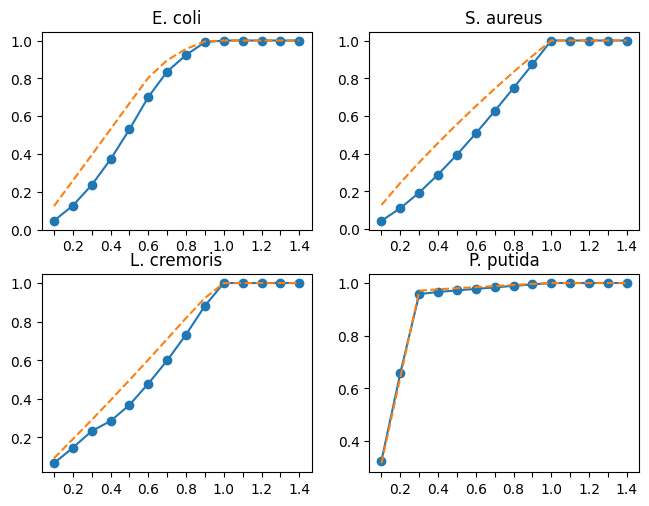

In [13]:
ex = ['ecoli','saureus','lcremoris','pputida']
fig,ax = plt.subplots(2,2,figsize = (5*1.34,5))
ax = ax.flatten()
plt.tight_layout()
for idx,org in enumerate(ex):
    plot(org,"mg2",ax=ax[idx])
    ax[idx].set_title(names[org])
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig("./figures/metal_examples.svg",format="SVG")

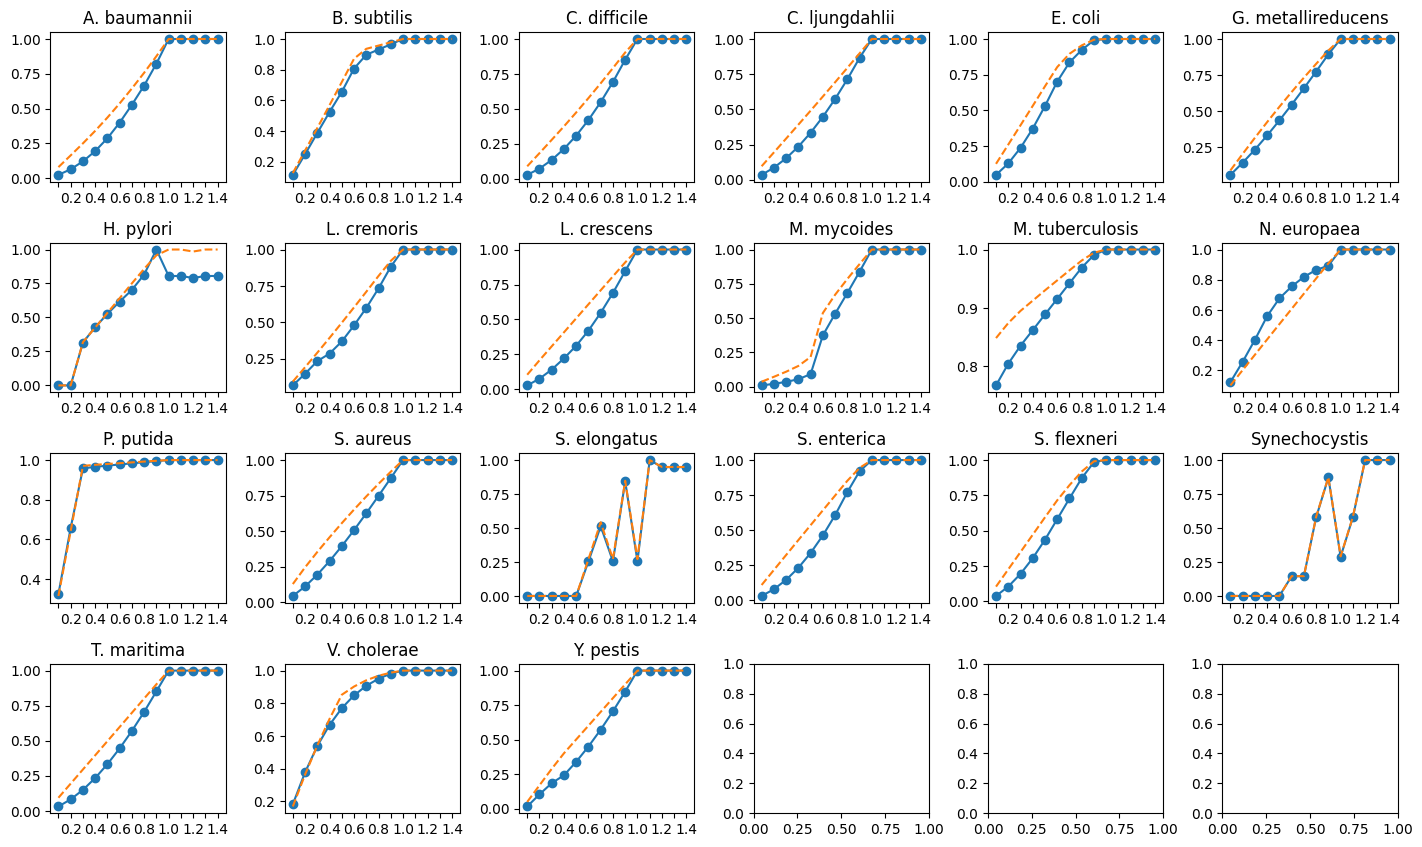

In [14]:
ex = sorted(list(models['clean'].keys()))
fig,ax = plt.subplots(4,6,figsize = (20/1.4,12/1.4))
ax = ax.flatten()
plt.tight_layout
for idx,org in enumerate(ex):
    plot(org,"mg2",ax=ax[idx])
    ax[idx].set_title(names[org])
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig("./figures/mg2_all.svg",format="SVG")